In [1]:
import subprocess
import os
import numpy as np
import re
import itertools
import pandas as pd
from Bio import SeqIO
from Bio import Phylo
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from joblib import Parallel,delayed
from math import *
import multiprocessing
import time

### Gathering the genomes with their names associated

Dict : GCF -> (Specie name,fnaPath,faaPath)

In [2]:
def DownloadingSequences(bacteriaPath,archeaPath,outputPath):
    
    print("Downloading Bacteria Files")
    subprocess.run("ncbi-genome-download --genera \'"+bacteriaPath+"\' bacteria -F protein-fasta,fasta -o "+outputPath,shell=True)
    
    print("Downloading Archaea Files")
    subprocess.run("ncbi-genome-download --genera \'"+archeaPath+"\' archaea -F protein-fasta,fasta -o "+outputPath,shell=True)
        
    CleaningFolder(outputPath)	

def CleaningFolder(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.gz'):
                subprocess.run("gunzip "+root+"/"+file,shell=True)
            if file=="MD5SUMS":
                subprocess.run("rm "+root+"/"+file,shell=True)
            
            
DownloadingSequences('../../data/Bacteria.list','../../data/Archea.list','../../data/')

KeyboardInterrupt: 

##### Generating a dictionnary with Keys : species names and values:  faa/fna corresponding file paths

In [2]:
#Returns a dictionnary: Key: Phylum -> Value Other dictionnary | Organism name -> Path to Proteome and Genome

def ParsingSequences(path):
    #Dictionnary of all the adresses
    dictGen={}
    #Getting the species names via Regular expression
    regex="[0-9] (.+)(chromosome|,)"
    
    listPhylums=os.listdir(path)
    listFiles=[[] for _ in range(len(listPhylums))]
    for i in range(len(listPhylums)):
        listfaa=[]
        listfna=[]
        listNames=[]
        for root,dirs,files in os.walk(path+'/'+listPhylums[i]):
            for file in files:
                if file.endswith('.faa'):
                    listfaa.append(root+'/'+file)
                elif file.endswith('.fna'):
                    listfna.append(root+'/'+file)
                    lineSpecie=open(root+'/'+file).readlines()[0]
                    match=re.search(regex,lineSpecie).group(1)
                    if match.split(' ')[-1]=='chromosome':
                        match=' '.join(match.split(' ')[:-1])
                    listNames.append(match)    
        dictGen[listPhylums[i]]=dict(zip(listNames,zip(listfaa,listfna)))          
        
    return dictGen

In [3]:
pathGenomes='../../data/refseq/'
dictGeneral=ParsingSequences(pathGenomes)

print("Number of Bacterias:",len(dictGeneral['bacteria'].keys()))
print("Number of Archaeas:",len(dictGeneral['archaea'].keys()))

Number of Bacterias: 99
Number of Archaeas: 44


Only 44/55 Archeas Donwloaded

### Missing organisms

In [4]:
listBacterias=[i[:-1] for i in open('../../data/Bacteria.list','r').readlines()[1:]]
listArchaeas=[i[:-1] for i in open('../../data/Archea.list','r').readlines()[1:]]


print('Bacterias:','\n')
for i in listBacterias:
    if i not in dictGeneral['bacteria'].keys():
        print(i)
        
print('Archaeas:','\n')    
for i in listArchaeas:
    if i not in dictGeneral['archaea'].keys():
        print(i)

Bacterias: 

Borrelia burgdorferi B31
Candidatus Cloacamonas acidaminovorans
Candidatus Endomicrobium sp. Rs-D17
Cupriavidus taiwanensis
Cupriavidus taiwanensis
Cyanothece sp. ATCC 51142
Cyanothece sp. ATCC 51142
Dehalococcoides ethenogenes 195
Deinococcus radiodurans R1
Deinococcus radiodurans R1
Fusobacterium nucleatum subsp. nucleatum ATCC 25586
Gemmata obscuriglobus UQM 2246
Leptospira interrogans serovar Lai str. 56601
Leptospira interrogans serovar Lai str. 56601
Magnetococcus sp. MC-1
Solibacter usitatus Ellin6076
Thermoanaerobacter tengcongensis MB4
Thermobaculum terrenum ATCC BAA-798
Thermobaculum terrenum ATCC BAA-798
Thermus thermophilus HB8
Archaeas: 

Candidatus Methanoregula boonei 6A8
Candidatus Methanosphaerula palustris E1-9c
Cenarchaeum symbiosum A
Desulfurococcus kamchatkensis 1221n
Halobacterium sp. NRC-1
Halorubrum lacusprofundi ATCC 49239
Halorubrum lacusprofundi ATCC 49239
Methanosaeta thermophila PT
Nanoarchaeum equitans Kin4-M
Sulfolobus solfataricus P2
Thermop

### Read sequence from file

In [4]:
def ReadSequence(path):
    seqs=SeqIO.parse(path,'fasta')
    seqs=[str(seq.seq) for seq in seqs]
    return ''.join(seqs)

### Compute K-Mers

In [5]:
def Cut(sequence,size):
    return [sequence[i:i+size] for i in range(len(sequence)-(size-1)) ]

def CountCuts(listOfSequences,normalized=False):
    
    #Creating the dictionnary
    possibilities=list(map(''.join,list(itertools.product('ACGT', repeat=len(listOfSequences[0])))))
    counts=[0 for i in range(len(possibilities))]
    dicoCuts=dict(zip(possibilities,counts))
    
    #Counting sequences
    for sequence in listOfSequences:
        try:
            dicoCuts[sequence]+=1
        except:
            None
    
    #Conversion to df
    df=pd.DataFrame([dicoCuts])

    
    if normalized==False:        
        return df
    else:
        return df/np.sum(df.values)
 
def CountKMerFromFile(path,size):
    sequence=ReadSequence(path)
    cutList=Cut(sequence,size)
    return CountCuts(cutList,normalized=True)

def Chi2HomogeneityFromFile(path1,path2,size):
    count1=CountKMerFromFile(path1,size).values[0]
    count2=CountKMerFromFile(path2,size).values[0]
    contingency=np.vstack((count1,count2))
    pVal=chi2_contingency(contingency)[0]
    return pVal

def ComputeDistanceFromCounts(dict1,dict2):
    distances=(dict1-dict2)**2
    return np.sum(distances)

def DistanceFromFile(path1,path2,size):
    count1=CountKMerFromFile(path1,size).values[0]
    count2=CountKMerFromFile(path2,size).values[0]
    distance=ComputeDistanceFromCounts(count1,count2)
    return distance

### Quick Look at the dataset

In [6]:
pathTest=dictGeneral['archaea']['Methanosarcina mazei Go1']

In [7]:
seqTest=ReadSequence(pathTest[1])
seqCuttesTest=Cut(seqTest,3)
dicSeq=CountCuts(seqCuttesTest,normalized=True)
dicSeq

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,0.040144,0.015372,0.022672,0.025282,0.0142,0.011276,0.006642,0.012942,0.020489,0.013949,...,0.008386,0.020299,0.019114,0.015348,0.012114,0.014273,0.020452,0.025448,0.016921,0.039499


<BarContainer object of 64 artists>

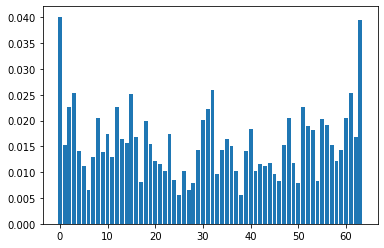

In [8]:
plt.bar(np.arange(0,len(dicSeq.columns),1),dicSeq.values[0])

#### Computing some distances

In [58]:
keys=np.array(list(dictGeneral['bacteria'].keys())[0:10])
keyShort=[i[0:5] for i in keys]

distanceDf=pd.DataFrame(data=None,index=keys,columns=keyShort)

#Output path
nomFi='../../data/distanceMatrix.csv'


start = time.time()
for i in range(len(keys)):
    for j in range(i,len(keys)):
        if i!=j:
            print("Computing. ",keys[i],"vs",keys[j])
            distance=DistanceFromFile(dictGeneral['bacteria'][keys[i]][1],dictGeneral['bacteria'][keys[j]][1],3)
            print('Pvalue:',distance,'\n')
            distanceDf.loc[keyShort[i],keyShort[j]]=distance
            distanceDf.loc[keyShort[j],keyShort[i]]=distance
        else:
            distanceDf.loc[keyShort[i],keyShort[j]]=0
            

distanceDf.to_csv(nomFi,sep=',')
end = time.time()

print("elapsed time:",end-start)

##### Get the results

In [51]:
distanceDf=pd.read_csv(nomFi,sep=',',index_col=0)

In [52]:
distanceDf

,Cupriavidus taiwanensis isolate Cupriavidus taiwanensis STM 8561 chromosome CBM2618_a,Cupriavidus taiwanensis isolate Cupriavidus taiwanensis TPUD 27.6 chromosome CBM2631_a,Shewanella putrefaciens CN-32,Cupriavidus taiwanensis strain USM6 USM6_assembled_contig_1,Bacteroides fragilis YCH46,Cupriavidus taiwanensis isolate Cupriavidus taiwanensis STM 6044,Coxiella burnetii RSA 493,Deinococcus radiodurans R1 chromosome 1,Thermotoga maritima MSB8,Pedobacter heparinus DSM 2366 ctg7180000000005_quiver
Cupriavidus taiwanensis isolate Cupriavidus taiwanensis TPUD 27.6 chromosome CBM2631_a,1.748565e-07,0.000000e+00,0.011324,0.000020,0.013188,0.000010,0.013551,0.000737,0.013998,0.014609
Cupriavidus taiwanensis isolate Cupriavidus taiwanensis STM 8561 chromosome CBM2618_a,0.000000e+00,1.748565e-07,0.011392,0.000017,0.013263,0.000011,0.013623,0.000749,0.014081,0.014679
Shewanella putrefaciens CN-32,1.139217e-02,1.132398e-02,0.000000,0.012077,0.000799,0.010926,0.000828,0.009823,0.003447,0.000836
Cupriavidus taiwanensis strain USM6 USM6_assembled_contig_1,1.683896e-05,1.973305e-05,0.012077,0.000000,0.014026,0.000040,0.014331,0.000864,0.014886,0.015428
Bacteroides fragilis YCH46,1.326344e-02,1.318845e-02,0.000799,0.014026,0.000000,0.012733,0.001016,0.011378,0.001939,0.000772
Cupriavidus taiwanensis isolate Cupriavidus taiwanensis STM 6044,1.141883e-05,9.859649e-06,0.010926,0.000040,0.012733,0.000000,0.013143,0.000696,0.013553,0.014154
Coxiella burnetii RSA 493,1.362318e-02,1.355050e-02,0.000828,0.014331,0.001016,0.013143,0.000000,0.011765,0.003557,0.000956
Deinococcus radiodurans R1 chromosome 1,7.485495e-04,7.369266e-04,0.009823,0.000864,0.011378,0.000696,0.011765,0.000000,0.011496,0.012669
Thermotoga maritima MSB8,1.408109e-02,1.399775e-02,0.003447,0.014886,0.001939,0.013553,0.003557,0.011496,0.000000,0.003722
Pedobacter heparinus DSM 2366 ctg7180000000005_quiver,1.467938e-02,1.460916e-02,0.000836,0.015428,0.000772,0.014154,0.000956,0.012669,0.003722,0.000000


In [24]:
newValues=distanceDf.values
nrow,ncol=(newValues.shape)
minimum=np.min(newValues)
maximum=np.max(newValues)
minscaled=0
maxScaled=10
for i in range(nrow):
    for j in range(ncol):
        newValues[i,j]=(newValues[i,j]/(minimum+maximum))*(maxScaled-minscaled)


In [30]:
newValue=pd.DataFrame(data=newValues,columns=keys,index=keys)
newValue

,Cupriavidus taiwanensis isolate Cupriavidus taiwanensis STM 8561 chromosome CBM2618_a,Cupriavidus taiwanensis isolate Cupriavidus taiwanensis TPUD 27.6 chromosome CBM2631_a,Shewanella putrefaciens CN-32,Cupriavidus taiwanensis strain USM6 USM6_assembled_contig_1,Bacteroides fragilis YCH46,Cupriavidus taiwanensis isolate Cupriavidus taiwanensis STM 6044,Coxiella burnetii RSA 493,Deinococcus radiodurans R1 chromosome 1,Thermotoga maritima MSB8,Pedobacter heparinus DSM 2366 ctg7180000000005_quiver
Cupriavidus taiwanensis isolate Cupriavidus taiwanensis STM 8561 chromosome CBM2618_a,0.000000,0.000113,7.383917,0.010914,8.596794,0.007401,8.829960,0.485178,9.126758,9.514543
Cupriavidus taiwanensis isolate Cupriavidus taiwanensis TPUD 27.6 chromosome CBM2631_a,0.000113,0.000000,7.339715,0.012790,8.548188,0.006391,8.782852,0.477644,9.072742,9.469031
Shewanella putrefaciens CN-32,7.383917,7.339715,0.000000,7.827949,0.517728,7.081459,0.536636,6.367024,2.234329,0.542087
Cupriavidus taiwanensis strain USM6 USM6_assembled_contig_1,0.010914,0.012790,7.827949,0.000000,9.091134,0.026033,9.288982,0.560042,9.648323,10.000000
Bacteroides fragilis YCH46,8.596794,8.548188,0.517728,9.091134,0.000000,8.253219,0.658446,7.374806,1.256645,0.500656
Cupriavidus taiwanensis isolate Cupriavidus taiwanensis STM 6044,0.007401,0.006391,7.081459,0.026033,8.253219,0.000000,8.518525,0.450916,8.784492,9.173869
Coxiella burnetii RSA 493,8.829960,8.782852,0.536636,9.288982,0.658446,8.518525,0.000000,7.625774,2.305512,0.619821
Deinococcus radiodurans R1 chromosome 1,0.485178,0.477644,6.367024,0.560042,7.374806,0.450916,7.625774,0.000000,7.451389,8.211465
Thermotoga maritima MSB8,9.126758,9.072742,2.234329,9.648323,1.256645,8.784492,2.305512,7.451389,0.000000,2.412304
Pedobacter heparinus DSM 2366 ctg7180000000005_quiver,9.514543,9.469031,0.542087,10.000000,0.500656,9.173869,0.619821,8.211465,2.412304,0.000000


##### Running NeighbourJoining on distances

In [22]:
class noeud_NJ:
    """Class qui défini un noeud tel que:
    -son nom
    -fils gauche
    -fils droit
    -sa hauteur
    -nombre d'élement gauche
    -nombre d'élement droit"""
    def __init__(self,nom,fg,fd,hauteur):
        self.nom=nom
        self.fg=fg
        self.fd=fd
        self.hauteur=hauteur

def distanceminimal_NJ(matrice):
    imin=1
    jmin=0
    minimal=matrice[imin][jmin]
    for i in range(1,len(matrice)):
        for j in range(0,i):
            if matrice[i][j]<minimal:
                minimal=matrice[i][j]
                imin=i
                jmin=j
    return(imin,jmin)

def nom_colonne(matrice):
    listenom=[]
    for i in range(1,len(matrice)+1):
        listenom.append(chr(i+64))
    return(listenom)
#Création de la liste qui stocke l'ensemble des distances de chaque élement
def liste_somme_distance(matrice):
    liste_U=[]
    somme=0
    for i in range(len(matrice)):
        for j in range(len(matrice)):
            if i!=j:
                somme+=matrice.iloc[i][j]
        liste_U.append(somme/(len(matrice)-2))
        somme=0
    return(liste_U)

#Initialisation de la matrice Q qui pour chaque paire d'éléments renvoit une distance 
def init_matriceQ(matrice,liste_U):
    matriceQ=np.zeros((len(matrice),len(matrice)))
    for i in range(len(matrice)):
        for j in range(len(matrice)):
            if i!=j:
                matriceQ[i][j]=((matrice.iloc[i][j]-liste_U[i]-liste_U[j]))
    return(matriceQ)


#Création à partir d'une liste de noms des élements la liste des feuilles à la classe voulue 
def creer_feuille_NJ(listenom):
    listefeuilles=[]
    for i in listenom:
        listefeuilles.append(noeud_NJ(i,"","",0))
    return(listefeuilles)

#Création d'un nouveau noeud qui va remplacer les 2 valeurs les plus proches 
def creer_noeud_NJ(i,j,listenoeud,liste_U,matrice):
    noeudt=noeud_NJ(listenoeud[i].nom+listenoeud[j].nom,
          listenoeud[i],
          listenoeud[j],
          0)
    listenoeud[i].hauteur=(matrice.iloc[i][j]+liste_U[i]-liste_U[j])/2
    listenoeud[j].hauteur=(matrice.iloc[i][j]+liste_U[j]-liste_U[i])/2
    del listenoeud[i]
    del listenoeud[j]
    return noeudt

#Mise à jour de la matrice et de la liste des noeuds pour chaque itération dans la fonction NJ
def maj_matrice_NJ(matrice,listenoeud):
    liste_U=liste_somme_distance(matrice)#Définition de l'ensemble des distances
    matrice_Q=init_matriceQ(matrice,liste_U)#Création de la matrice_Q de distance
    i,j=distanceminimal_NJ(matrice_Q)#Détermination des éléments les plus proches et les plus éloignés des autres éléments
    x,y=listenoeud[i].nom,listenoeud[j].nom
    noeudt=creer_noeud_NJ(i,j,listenoeud,liste_U,matrice)
    matrice2=np.zeros((len(matrice)-1,len(matrice)-1))#Matrice qui permet la mise à jour
    
    t=0
    tt=0
    listenom=[]
    
    for it in listenoeud:
        listenom.append(it.nom)
    #Recopiage de la matrice de base dans la matrice à mettre à jour sans les éléments les plus proches
    for l in listenom:
        for c in listenom:
            matrice2[t][tt]=matrice.loc[l][c]
            tt=tt+1
        t=t+1
        tt=0
    #Ajout du nouveau noeud formé
    listenom.append(noeudt.nom)
    listenoeud.append(noeudt)
    matrice2_df=pd.DataFrame(matrice2,listenom,listenom)

    #Ajout des distances au nouveau noeud dans la matrice à mettre à jour
    for t in range(len(listenom)-1):
        matrice2_df.loc[noeudt.nom][listenom[t]]=(matrice.loc[x][listenom[t]]+matrice.loc[y][listenom[t]]-matrice.loc[x][y])/2
        matrice2_df.loc[listenom[t]][noeudt.nom]=(matrice.loc[x][listenom[t]]+matrice.loc[y][listenom[t]]-matrice.loc[x][y])/2
    return(matrice2_df)

#Fonction récursive qui renvoie une séquence en format Newick
def creer_arbre(noeud):
    if noeud.fg=="" and noeud.fd=="":
        return(noeud.nom+":"+str(noeud.hauteur))
    else:
        arbre="("+"("+creer_arbre(noeud.fd)+","+creer_arbre(noeud.fg)+")"+":"+str(noeud.hauteur)+")"
        
    return arbre
    
def NJ(matrice_df):
    listenom=list(matrice_df.index)
    listenoeud=creer_feuille_NJ(listenom)
    matrice_maj=maj_matrice_NJ(matrice_df,listenoeud)
    #Si il ne reste qu'une valeur on ne peut pas la comparer à une autre donc on s'arrête quand il en reste 2
    while len(matrice_maj)>2:
        matrice_maj=maj_matrice_NJ(matrice_maj,listenoeud)
    arbre=""
    for noeud in listenoeud:
        arbre+=creer_arbre(noeud)
    fichier=open("arbre_NJ.txt","w")
    for i in arbre:
        fichier.write(i)
    print(arbre)
    fichier.close()
    tree=Phylo.read("arbre_NJ.txt",'newick')
    Phylo.draw(tree) 
    

((Cupriavidus taiwanensis isolate Cupriavidus taiwanensis TPUD 27.6 chromosome CBM2631_a:-0.04048701744384735,((Cupriavidus taiwanensis isolate Cupriavidus taiwanensis STM 6044 :-0.12314372747329105,((Deinococcus radiodurans R1 chromosome 1:-0.3848058441038251,((Shewanella putrefaciens CN-32:-0.07775142533581647,((Thermotoga maritima MSB8:1.1125270390964568,((Bacteroides fragilis YCH46:0.006400093752501057,((Coxiella burnetii RSA 493:0.10508156414742187,Pedobacter heparinus DSM 2366 ctg7180000000005_quiver:0.5147398559806793):0.26324028382967146)):0.40547360938662624)):0.5553000415881493)):6.6521249524707535)):0.806722619059914)):0.1186218887413133)):0)((Cupriavidus taiwanensis isolate Cupriavidus taiwanensis STM 8561 chromosome CBM2618_a:-0.034296952101746006,Cupriavidus taiwanensis strain USM6 USM6_assembled_contig_1:0.04521124346018332):0)


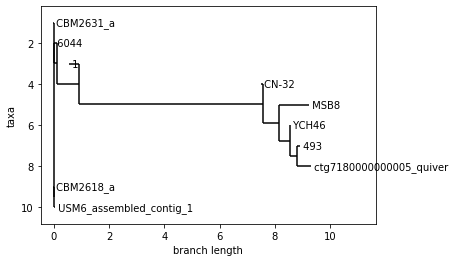

In [31]:
NJ(distanceDf)